Scanning interfaces for Crazyflies...
Crazyflies found:
radio://0/16/2M
radio://0/16/2M
radio://0/16/2M
radio://0/16/2M
radio://0/16/2M
radio://0/16/2M
Capturing.....
Initializing PID Controller
Capturing.....
Checking image:
4553.5
Adjusting position
Setting position [0, -0.1, 0.5, 0.0]
Setting position [0, -0.2, 0.5, 0.0]
Setting position [0, -0.30000000000000004, 0.5, 0.0]
Setting position [0, -0.4, 0.5, 0.0]
Setting position [0, -0.5, 0.5, 0.0]
Setting position [0, -0.6, 0.5, 0.0]
Setting position [0, -0.7, 0.5, 0.0]
Setting position [0, -0.7999999999999999, 0.5, 0.0]
Setting position [0, -0.8999999999999999, 0.5, 0.0]
Setting position [0, -0.9999999999999999, 0.5, 0.0]
Capturing.....
Checking image:
1322.0
Adjusting position
Setting position [0, -1.0999999999999999, 0.5, 0.0]
Setting position [0, -1.2, 0.5, 0.0]
Setting position [0, -1.3, 0.5, 0.0]
Setting position [0, -1.4000000000000001, 0.5, 0.0]
Setting position [0, -1.5000000000000002, 0.5, 0.0]
Setting position [0, -1.600000

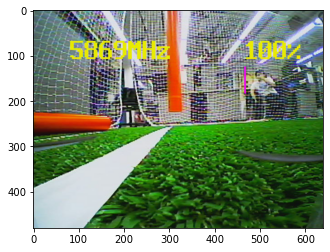

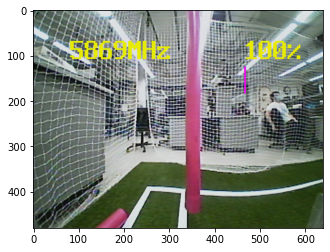

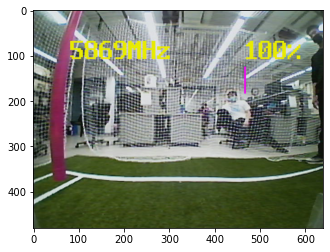

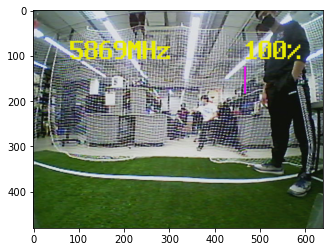

In [8]:
group_number = 16

# Possibly try 0, 1, 2 ...
camera = 0

# Code adapted from: https://github.com/bitcraze/crazyflie-lib-python/blob/master/examples/autonomousSequence.py

import time
# CrazyFlie imports:
import cflib.crtp
from cflib.crazyflie import Crazyflie
from cflib.crazyflie.log import LogConfig
from cflib.crazyflie.syncCrazyflie import SyncCrazyflie
from cflib.crazyflie.syncLogger import SyncLogger
from cflib.positioning.position_hl_commander import PositionHlCommander
import numpy as np
import cv2




## Some helper functions:
## -----------------------------------------------------------------------------------------

# Ascend and hover:
def set_PID_controller(cf):
    # Set the PID Controller:
    print('Initializing PID Controller')
    cf.param.set_value('stabilizer.controller', '1')
    cf.param.set_value('kalman.resetEstimation', '1')
    time.sleep(0.1)
    cf.param.set_value('kalman.resetEstimation', '0')
    time.sleep(2)
    return

# Ascend and hover:
def ascend_and_hover(cf):
    # Ascend:
    for y in range(5):
        cf.commander.send_hover_setpoint(0, 0, 0, y / 10)
        time.sleep(0.1)
    # Hover at 0.5 meters:
    for _ in range(20):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    return


def findGreatesContour(contours):
    largest_area = 0
    largest_contour_index = -1
    i = 0
    total_contours = len(contours)

    while i < total_contours:
        area = cv2.contourArea(contours[i])
        if area > largest_area:
            largest_area = area
            largest_contour_index = i
        i += 1

    #print(largest_area)

    return largest_area, largest_contour_index


def check_contours(frame):

    print('Checking image:')

    # Do the contour detection on the input frame
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

    # Compute
    mask0 = cv2.inRange(hsv, np.array([0, 50, 50]), np.array([10, 255, 255]))
    mask1 = cv2.inRange(hsv, np.array([170, 50, 50]), np.array([180, 255, 255]))
    test_mask = mask0 + mask1
    contours, _ = cv2.findContours(test_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    largest_area, largest_contour_index = findGreatesContour(contours)

    print(largest_area)
    if largest_area > 500:
        largest_contour = contours[largest_contour_index]
        center = np.mean(largest_contour, axis=0)[0] # Should give [x, y]
        print(center)
        if (240 <= center[0] <= 320):
            return True, -0.3
        elif (320 <= center[0] <= 400):
            return True, 0.3
        else:
            return False
    return False


# Follow the setpoint sequence trajectory:
def adjust_position(cf, current_y, y_adjust, current_x):

    print('Adjusting position')

    steps_per_meter = int(10)
    for i in range(steps_per_meter):
        current_y = current_y + y_adjust/float(steps_per_meter)
        position = [current_x, current_y, 0.5, 0.0]

        print('Setting position {}'.format(position))
        for i in range(10):
            cf.commander.send_position_setpoint(position[0],
                                                position[1],
                                                position[2],
                                                position[3])
            time.sleep(0.1)

    # cf.commander.send_stop_setpoint()
    # Make sure that the last packet leaves before the link is closed
    # since the message queue is not flushed before closing
    time.sleep(0.1)
    return current_y

def move_forward(cf, current_x, x_adjust, current_y):

    print('Move Forward')

    steps_per_meter = int(10)
    for i in range(steps_per_meter):
        current_x = current_x + x_adjust/float(steps_per_meter)
        position = [current_y, current_y, 0.5, 0.0]

        print('Setting position {}'.format(position))
        for i in range(10):
            cf.commander.send_position_setpoint(position[0],
                                                position[1],
                                                position[2],
                                                position[3])
            time.sleep(0.1)

    # cf.commander.send_stop_setpoint()
    # Make sure that the last packet leaves before the link is closed
    # since the message queue is not flushed before closing
    time.sleep(0.1)
    return current_y

# Hover, descend, and stop all motion:
def hover_and_descend(cf):
    print('Descending:')
    # Hover at 0.5 meters:
    for _ in range(30):
        cf.commander.send_hover_setpoint(0, 0, 0, 0.5)
        time.sleep(0.1)
    # Descend:
    for y in range(10):
        cf.commander.send_hover_setpoint(0, 0, 0, (10 - y) / 25)
        time.sleep(0.1)
    # Stop all motion:
    for i in range(10):
        cf.commander.send_stop_setpoint()
        time.sleep(0.1)
    return

## -----------------------------------------------------------------------------------------

## The following code is the main logic that is executed when this script is run

## -----------------------------------------------------------------------------------------
# Set the URI the Crazyflie will connect to
uri = f'radio://0/{group_number}/2M'

# Initialize all the CrazyFlie drivers:
cflib.crtp.init_drivers(enable_debug_driver=False)

# Scan for Crazyflies in range of the antenna:
print('Scanning interfaces for Crazyflies...')
available = cflib.crtp.scan_interfaces()

# List local CrazyFlie devices:
print('Crazyflies found:')
for i in available:
    print(i[0])

# Check that CrazyFlie devices are available:
if len(available) == 0:
    print('No Crazyflies found, cannot run example')
else:
    ## Ascent to hover; run the sequence; then descend from hover:
    # Use the CrazyFlie corresponding to team number:
    with SyncCrazyflie(uri, cf=Crazyflie(rw_cache='./cache')) as scf:
        # Get the Crazyflie class instance:
        cf = scf.cf
        current_y = 0.0
        current_x = 0.0

        # Initialize and ascend:
        t = time.time()
        elapsed = time.time() - t
        ascended_bool = 0

        cap = cv2.VideoCapture(camera)
#         while(True):
#         # Capture frame-by-frame
#             ret, frame = cap.read()


#         # Display the resulting frame
#             cv2.imshow('frame', frame)

#         # Hit q to quit.
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break
        while(cap.isOpened()):

            ret, frame = cap.read()

            elapsed = time.time() - t
            if(elapsed > 5.0):

                print('Capturing.....')

                if ret:
                    import matplotlib.pyplot as plt
                    b,g,r = cv2.split(frame)       # get b,g,r
                    rgb_frame = cv2.merge([r,g,b])     # switch it to rgbplt.figure()
                    plt.figure()
                    plt.imshow(rgb_frame)
#                     cv2.imshow('frame',frame)

                    if(ascended_bool==0):
                        set_PID_controller(cf)
                        ascend_and_hover(cf)
                        ascended_bool = 1
                    else:
                        suc, y_adjust = check_contours(frame)
                        if(suc):
                            current_y = adjust_position(cf, current_y, y_adjust, current_x)
                        else:
                            current_x = move_forward(cf, current_x, 0.5, current_y)

            if(elapsed > 30.0):
                        break

        cap.release()

        # Descend and stop all motion:
        hover_and_descend(cf)

print('Done!')


In [5]:
import numpy as np
import cv2

# This may open your webcam instead of the CrazyFlie camera! If so, try
# a different small, positive integer, e.g. 1, 2, 3.
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()


    # Display the resulting frame
    cv2.imshow('frame', frame)

    # Hit q to quit.
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()


KeyboardInterrupt: 

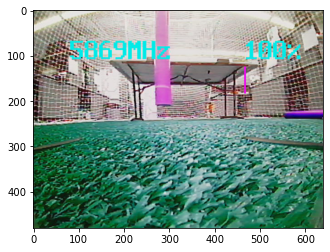